In [1]:
import pandas as pd
from pandas import Timestamp as tmpstemp
from pandas import Timedelta as tmpdelta
import cbpro
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from portfolio import Portfolio, Asset

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_112794/1645487527.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-20 16:30:39.703608: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
USD = Asset('USD')
date_range = pd.date_range(start=tmpstemp.fromisoformat('2000-01-01'), end=tmpstemp.today())
idx =pd.DatetimeIndex(date_range, name = 'date_time')
USD_2000 = pd.DataFrame({'low':[1] * len(idx), 'high':[1] * len(idx),
                    'open':[1] * len(idx), 'close':[1] * len(idx),
                    'volume':[1000]* len(idx)},
                     index=idx)
USD.update_history(USD_2000)

In [3]:
with open('CoinBaseAPIKey.key', 'r') as f:
    contents = f.readlines()
cb_key = contents[0].split(':')[-1].strip()
cb_secret = contents[1].split(':')[-1].strip()

In [4]:
#Download data
public_client = cbpro.PublicClient()
slots = [('2023-01-01', '2023-06-01'), ('2022-07-01', '2022-12-31'), ('2022-01-01', '2022-06-30'), ('2023-06-02', '2023-12-01')]
BTC = Asset('BTC')
ETH = Asset('ETH')
USDT = Asset('USDT')

for slot in slots:
    BTC_USD = public_client.get_product_historic_rates('BTC-USD', slot[0], slot[1], 86400)
    ETH_USD = public_client.get_product_historic_rates('ETH-USD', slot[0], slot[1], 86400)
    USDT_USD = public_client.get_product_historic_rates('USDT-USD', slot[0], slot[1], 86400)
    btc_data= pd.DataFrame(BTC_USD)
    btc_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    btc_data['date_time']= btc_data['date_time'].apply(lambda x: tmpstemp.fromtimestamp(x))
    btc_data.set_index('date_time', inplace=True)
    BTC.update_history(btc_data)

    ETH_data= pd.DataFrame(ETH_USD)
    ETH_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    ETH_data['date_time']= ETH_data['date_time'].apply(lambda x: tmpstemp.fromtimestamp(x))
    ETH_data.set_index('date_time', inplace=True)
    ETH.update_history(ETH_data)

    USDT_data= pd.DataFrame(USDT_USD)
    USDT_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    USDT_data['date_time']= USDT_data['date_time'].apply(lambda x: tmpstemp.fromtimestamp(x))
    USDT_data.set_index('date_time', inplace=True)
    USDT.update_history(USDT_data)

In [5]:
my_portfolio = Portfolio(origination_date=tmpstemp.fromisoformat('2021-12-01'), initial_deposit=100)
my_portfolio.update_transactions(ticker='BTC', qty=1, transaction_date=tmpstemp.fromisoformat('2022-01-01'))
my_portfolio.update_transactions(ticker='USDT', qty=40000, transaction_date=tmpstemp.fromisoformat('2022-01-01'))
my_portfolio.update_transactions(ticker='BTC', qty=-0.5, transaction_date=tmpstemp.fromisoformat('2022-01-02'))
my_portfolio.update_transactions(ticker='USDT', qty=-10000, transaction_date=tmpstemp.fromisoformat('2022-01-02'))
my_portfolio.update_transactions(ticker='BTC', qty=-0.25, transaction_date=tmpstemp.fromisoformat('2022-01-10'))
my_portfolio.update_transactions(ticker='USDT', qty=-20000, transaction_date=tmpstemp.fromisoformat('2022-01-10'))
my_portfolio.transactions

change             note
date_time  ticker                         
2021-12-01 USD        100  Initial deposit
2022-01-01 BTC          1                 
           USDT     40000                 
2022-01-02 BTC       -0.5                 
           USDT    -10000                 
2022-01-10 BTC      -0.25                 
           USDT    -20000

In [6]:
'''
# Plot data we got
fig, ax = plt.subplots(1, 1, sharex = True)
fig.set_figheight(11)
fig.set_figwidth(8.5)
ax.plot(BTC.history.index, BTC.history['close'], color = 'black', label = 'Historic price')
for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        '''

"\n# Plot data we got\nfig, ax = plt.subplots(1, 1, sharex = True)\nfig.set_figheight(11)\nfig.set_figwidth(8.5)\nax.plot(BTC.history.index, BTC.history['close'], color = 'black', label = 'Historic price')\nfor tick in ax.get_xticklabels():\n        tick.set_rotation(45)\n        "

In [7]:
# Set up configuration objects and params
prediction_days = 15
scaler  = MinMaxScaler(feature_range=(0,1))
len_train = int(0.7*len(BTC.history))
len_test = len(BTC.history) - len_train
last_date_train = BTC.history.index[len_train]
first_date_val = BTC.history.index[len_train+1]

In [8]:
#Generate training data
x_train = []
y_train = []
scaled_data = scaler.fit_transform(np.array(BTC.history['close'].values).reshape(-1,1) )
for x in range(prediction_days, len_train):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])
x_train, y_train = (np.array(x_train), np.array(y_train))
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


(474, 15, 1)

In [9]:
# Create, compile, train the model
model = Sequential()
model.add(LSTM(units = 50, activation='tanh', return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
optimizer = Adam(learning_rate=0.001, name='Adam')

model.compile(optimizer = optimizer, loss = 'mse', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20, batch_size=8)

2024-04-20 16:30:43.931592: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2024-04-20 16:30:44.542296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-20 16:30:44.544185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-20 16:30:44.546590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-04-20 16:30:45.004217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-20 16:30:45.006456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-20 16:30:45.008162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

60/60 [==============================] - 13s 114ms/step - loss: 0.0281 - accuracy: 0.0021
Epoch 2/20
60/60 [==============================] - 7s 109ms/step - loss: 0.0090 - accuracy: 0.0021
Epoch 3/20
60/60 [==============================] - 9s 143ms/step - loss: 0.0076 - accuracy: 0.0021
Epoch 4/20
60/60 [==============================] - 6s 96ms/step - loss: 0.0084 - accuracy: 0.0021
Epoch 5/20
60/60 [==============================] - 7s 115ms/step - loss: 0.0083 - accuracy: 0.0021
Epoch 6/20
60/60 [==============================] - 5s 76ms/step - loss: 0.0077 - accuracy: 0.0021
Epoch 7/20
60/60 [==============================] - 6s 97ms/step - loss: 0.0068 - accuracy: 0.0021
Epoch 8/20
60/60 [==============================] - 6s 103ms/step - loss: 0.0065 - accuracy: 0.0021
Epoch 9/20
60/60 [==============================] - 6s 95ms/step - loss: 0.0074 - accuracy: 0.0021
Epoch 10/20
60/60 [==============================] - 6s 102ms/step - loss: 0.0065 - accuracy: 0.0021
Epoch 11/20
6

In [11]:
input_data = BTC.history['close'].loc[first_date_val-tmpdelta(days=prediction_days):]
prediction_prices = []
# Given the new data go one time point after another and make predictions 
for curr_date in input_data.index[(prediction_days-1):]:
    current_day_input = input_data[curr_date - tmpdelta(days=prediction_days-1):curr_date] # Data slice to be used in this step
    model_input = scaler.fit_transform(np.array(current_day_input.values).reshape(-1,1) )  # Data scaled as input for the model
    model_input = np.array(model_input).reshape(1,prediction_days,1)                       # Data shaped as input for the model
    pred_BTC_price = model.predict(model_input,verbose = 0)                                # Predict
    pred_BTC_price = scaler.inverse_transform(pred_BTC_price)[0][0]                        # Un-scale to get predicted asset price
    prediction_prices.append(pred_BTC_price)                                               # Save the result in the output array

    # Format string for output
    predicted_for_date = current_day_input.index[-1]+tmpdelta(days=1)                      # Get date we are predictig for 
    curr_BTC_price = input_data.loc[curr_date]                                             # Get current asset price 
    print(f'Today ({curr_date}):{curr_BTC_price}, predicted for {predicted_for_date}: {pred_BTC_price}')
 
    '''
    current_positions = my_portfolio.get_positions(curr_date)
    if pred_BTC_price > curr_BTC_price:
        my_portfolio.update_transactions(ticker='BTC',
                                    qty = 0.01 * current_positions.loc['BTC', 'position_size'],
                                    transaction_date=curr_date)
    '''

2024-04-20 16:33:12.608087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-20 16:33:12.610809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-20 16:33:12.613017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Today (2023-05-04 20:00:00):29536.76, predicted for 2023-05-05 20:00:00: 28770.21875
Today (2023-05-05 20:00:00):28902.66, predicted for 2023-05-06 20:00:00: 28834.91796875
Today (2023-05-06 20:00:00):28474.53, predicted for 2023-05-07 20:00:00: 28805.888671875
Today (2023-05-07 20:00:00):27695.06, predicted for 2023-05-08 20:00:00: 28662.59375
Today (2023-05-08 20:00:00):27647.29, predicted for 2023-05-09 20:00:00: 28473.302734375
Today (2023-05-09 20:00:00):27624.01, predicted for 2023-05-10 20:00:00: 28246.115234375
Today (2023-05-10 20:00:00):26986.56, predicted for 2023-05-11 20:00:00: 27886.220703125
Today (2023-05-11 20:00:00):26808.84, predicted for 2023-05-12 20:00:00: 27593.15234375
Today (2023-05-12 20:00:00):26789.48, predicted for 2023-05-13 20:00:00: 27342.423828125
Today (2023-05-13 20:00:00):26929.98, predicted for 2023-05-14 20:00:00: 27143.375
Today (2023-05-14 20:00:00):27171.13, predicted for 2023-05-15 20:00:00: 27019.2890625
Today (2023-05-15 20:00:00):27037.68, p

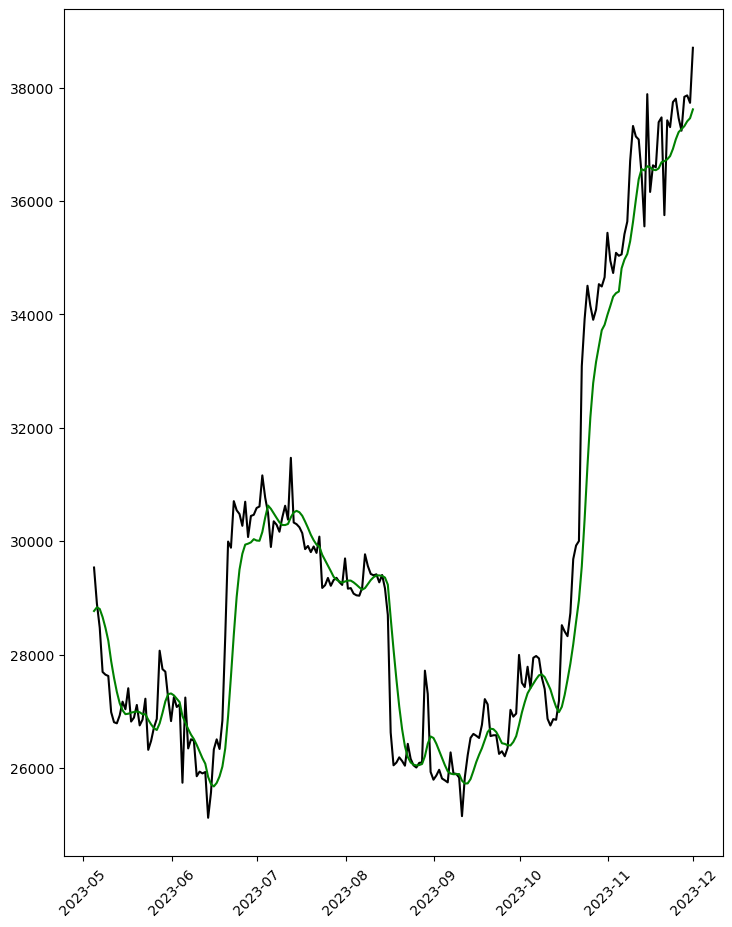

In [12]:
# Make data frame for final plotting
pred_df = pd.DataFrame(prediction_prices)
pred_df.columns = ['BTC_predicted']
plot_test = pd.concat([BTC.history.iloc[len_train:].reset_index(), pred_df[['BTC_predicted']].reset_index()], axis=1)

# Plot the results
fig, ax = plt.subplots(1, 1, sharex = True)
fig.set_figheight(11)
fig.set_figwidth(8.5)
ax.plot(plot_test['date_time'], plot_test['close'], color = 'black', label = 'Historic price')
ax.plot(plot_test['date_time'], plot_test['BTC_predicted'], color = 'green', label = 'Historic price')
for tick in ax.get_xticklabels():
        tick.set_rotation(45)